# input: 
seperate RFP and DAPI flourecent image pairs ( reffered to as red_img and blue_img)


In [8]:
# load images and set up paths


import numpy as np
from skimage.segmentation import expand_labels, watershed, find_boundaries
from scipy.ndimage import label as ndi_label, distance_transform_edt
import tifffile, cv2
from pathlib import Path
from skimage import morphology

notebook = Path(r"C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification\code\component development\rebuild.ipynb")

# go up to the project folder "lysozyme stain quantification"
project_root = notebook.parent.parent.parent



# Reuse existing 'pairs' if created earlier; otherwise build it quickly.
if 'pairs' not in globals():
    images_root = project_root / 'lysozyme images'
    red_files = sorted(list(images_root.rglob('*_RFP.tif')) + list(images_root.rglob('*_RFP.tiff')))
    def _match_blue(r_path: Path):
        stem = r_path.name
        if '_RFP.' not in stem:
            return None
        base = stem.split('_RFP.')[0]
        for ext in ['tif','tiff','TIF','TIFF']:
            cand = r_path.with_name(f'{base}_DAPI.{ext}')
            if cand.exists():
                return cand
        return None
    pairs = []
    for _r in red_files:
        b = _match_blue(_r)
        if b is not None:
            pairs.append((_r,b))
        if len(pairs) >= 30:
            break
    if not pairs:
        print('No RFP/DAPI pairs found. Aborting init cell.')

# Helper loaders (reuse if already defined).
if 'load_as_gray' not in globals():
    def load_as_gray(p: Path):
        arr = tifffile.imread(p)
        if arr.ndim == 3:
            if arr.shape[0] <= 4 and arr.shape[0] < arr.shape[-1]:
                arr = np.moveaxis(arr, 0, -1)
            if arr.shape[-1] in (3,4):
                arr = cv2.cvtColor(arr[..., :3].astype(np.uint8), cv2.COLOR_RGB2GRAY)
            else:
                arr = arr[...,0]
        return arr.astype(np.float32)
# Provided helper: minmax01
def minmax01(x, eps=1e-12):
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)


Using pair index 28: G3EL - 4_RFP.tif / G3EL - 4_DAPI.tif


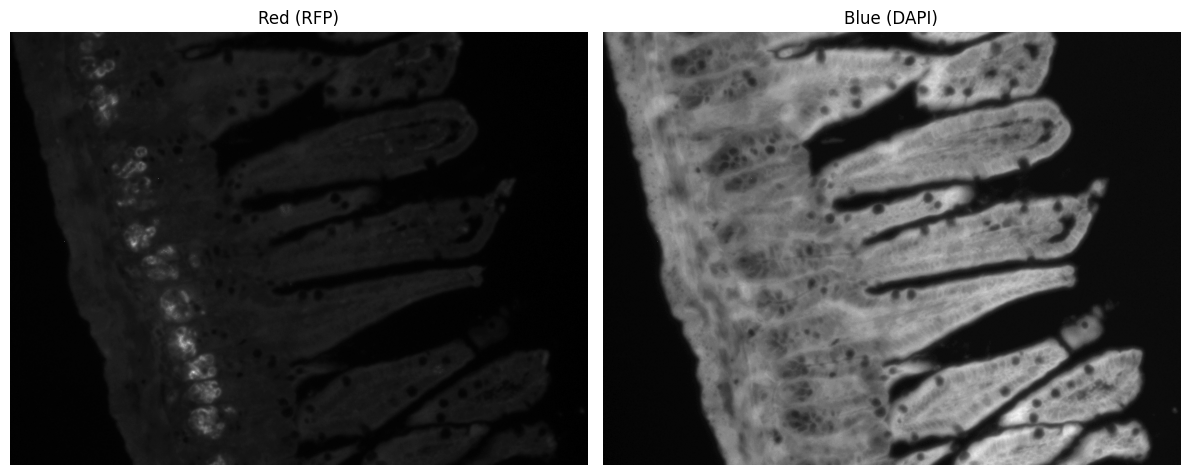

In [17]:

# pick a random pair from the first `max_samples` (change 30 to your desired cap)
max_samples = min(len(pairs), 30); idx = np.random.randint(0, max_samples)
red_img = load_as_gray(pairs[idx][0]); blue_img = load_as_gray(pairs[idx][1])
blue = blue_img; red = red_img  # DAPI, RFP
print(f"Using pair index {idx}: {pairs[idx][0].name} / {pairs[idx][1].name}")
import matplotlib.pyplot as plt

r_disp = minmax01(red_img); b_disp = minmax01(blue_img)

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) ; axes[0].imshow(r_disp, cmap='gray'); axes[0].set_title('Red (RFP)'); axes[1].imshow(b_disp, cmap='gray'); axes[1].set_title('Blue (DAPI)'); 
for ax in axes: ax.axis('off'); plt.tight_layout()
plt.show()


# pipeline:
    (red_image, blue_img) -> 
    grayscale ->  


## extractor_run: ->
    red_img & blue_img -> %%it looks like i dont normalize them%%
    prep grayscale masks: ->
        mask_r_dilation = np.maximum(blue, red) 
        mask_r_erosion = np.minimum(blue, red)
        %%these are np/ basicaly images of where each pixel value comes from whichever wins there%%
    


In [ ]:
mask_r_dilation = np.maximum(blue, red); mask_r_erosion = np.minimum(blue, red)
r_disp_mask = minmax01(mask_r_dilation); e_disp_mask = minmax01(mask_r_erosion)
fig, axes = plt.subplots(1, 2, figsize=(12, 6)); axes[0].imshow(r_disp_mask, cmap='gray'); axes[0].set_title('mask_r_dilation'); axes[1].imshow(e_disp_mask, cmap='gray'); axes[1].set_title('mask_r_erosion')
for ax in axes: ax.axis('off')
plt.tight_layout(); plt.show()

    diff_r = bool where red stronger than min envelope: ->
        diff_r = red > mask_r_erosion
    clean up diff_r: ->
        binary erosion with a 3x3 square kernel ->
        remove small objects less then 100 px area ->
    
    abs_diff = Secondary mask using absolute difference: -> 
        abs of mask_r_dilation - red
        mask_gt_red = abs_diff > red (this is a bool)
    then create the eroded mask

        


        
        get: (background_tissue_intensity, average_crypt_intensity)



    note: cant take combo straigt from imager as it preforms some sort of preproc that significantly changes the images, likely they are normalized on combined scales instead of seperate scales
